In [1]:
import psycopg2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
DB_PARAMS = {
    "dbname": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"), 
    "host": "postgres",
    "port":  5432
}

In [11]:
try:
    conn = psycopg2.connect(**DB_PARAMS)
    cursor = conn.cursor()
    cursor.execute(""" 
        SELECT event_time, 
            price::numeric,
            category_code, brand, user_id
        FROM customers
        WHERE event_type = 'purchase'
        AND event_time BETWEEN '2022-10-01' AND '2023-02-28 23:59:59'
        ORDER BY event_time
    """)
    rows = cursor.fetchall()
    data = pd.DataFrame(rows, columns=['event_time', 'price', 'category_code', 'brand', 'user_id'])

    cursor.close()
    conn.close()
except Exception as e:
    print(f"❌ An error occurred: {e}")

In [12]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

Estas dos líneas configuran el estilo y el tamaño de fuente de los gráficos generados con **Seaborn** y **Matplotlib**.

---

### 1. **`sns.set_style("whitegrid")`**
Esta línea configura el estilo visual de los gráficos generados con **Seaborn**. El estilo `"whitegrid"` agrega una cuadrícula blanca al fondo del gráfico, lo que facilita la lectura de los datos.

- **Opciones de estilo disponibles en Seaborn**:
  - `"darkgrid"`: Fondo oscuro con cuadrícula.
  - `"whitegrid"`: Fondo blanco con cuadrícula (el que estás usando).
  - `"dark"`: Fondo oscuro sin cuadrícula.
  - `"white"`: Fondo blanco sin cuadrícula.
  - `"ticks"`: Fondo blanco con marcas en los ejes.

**Ejemplo**:
```python
sns.set_style("whitegrid")
```
Esto hará que los gráficos tengan un fondo blanco con líneas de cuadrícula.

---

### 2. **`plt.rcParams.update({'font.size': 12})`**
Esta línea actualiza los parámetros de configuración de **Matplotlib** para establecer el tamaño de fuente predeterminado en los gráficos.

- **`'font.size'`**:
  - Controla el tamaño de la fuente en los textos de los gráficos, como etiquetas de los ejes, títulos, leyendas, etc.
  - En este caso, se establece en `12`.

**Ejemplo**:
```python
plt.rcParams.update({'font.size': 12})
```
Esto hará que todos los textos en los gráficos tengan un tamaño de fuente de 12 puntos.

---

### Resultado combinado
Cuando usas ambas líneas juntas:

```python
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})
```

- Los gráficos tendrán un fondo blanco con cuadrícula.
- El texto en los gráficos (etiquetas, títulos, etc.) tendrá un tamaño de fuente de 12 puntos.

Esto mejora la estética y la legibilidad de los gráficos. 😊

In [13]:
if not pd.api.types.is_datetime64_any_dtype(data['event_time']):
    data['event_time'] = pd.to_datetime(data['event_time'])

### ¿Qué hace?

1. **`pd.api.types.is_datetime64_any_dtype(data['event_time'])`**:
   - Verifica si la columna `event_time` del DataFrame `data` ya es de tipo `datetime64` (es decir, un tipo de dato de fecha y hora en pandas).

2. **`if not`**:
   - Si la columna **no** es de tipo `datetime64`, ejecuta el bloque de código dentro del `if`.

3. **`pd.to_datetime(data['event_time'])`**:
   - Convierte la columna `event_time` a tipo `datetime64`. Esto es necesario para realizar operaciones relacionadas con fechas, como agrupaciones por mes, día, etc.

---

### ¿Por qué es importante?

- Si `event_time` no está en formato `datetime`, no podrás realizar operaciones como:
  - Extraer el mes o el día (`data['event_time'].dt.month`).
  - Agrupar por períodos (`data['event_time'].dt.to_period('M')`).
  - Filtrar por rangos de fechas.

---

### Nota

Si la columna ya está en formato `datetime64`, la conversión no se realizará, lo que evita operaciones innecesarias y mejora el rendimiento. 😊

In [14]:
data['date'] = data['event_time'].dt.date
data['month'] = data['event_time'].dt.to_period('M')
data['month_str'] = data['month'].dt.strftime('%b')

### 1. **`data['date'] = data['event_time'].dt.date`**
- Extrae solo la parte de la fecha (sin la hora) de la columna `event_time`.
- Crea una nueva columna `date` que contiene únicamente la fecha en formato `YYYY-MM-DD`.

**Ejemplo**:
Si `event_time` es `2022-10-01 12:00:00`, entonces:
```python
data['date'] = 2022-10-01
```

---

### 2. **`data['month'] = data['event_time'].dt.to_period('M')`**
- Convierte la columna `event_time` en períodos mensuales.
- Crea una nueva columna `month` que contiene el mes y el año en formato `YYYY-MM`.

**Ejemplo**:
Si `event_time` es `2022-10-01 12:00:00`, entonces:
```python
data['month'] = 2022-10
```

---

### 3. **`data['month_str'] = data['month'].dt.strftime('%b')`**
- Convierte la columna `month` en una representación de texto del mes.
- Crea una nueva columna `month_str` que contiene el nombre abreviado del mes (por ejemplo, `Jan`, `Feb`, etc.).

**Ejemplo**:
Si `month` es `2022-10`, entonces:
```python
data['month_str'] = Oct
```

---

### ¿Por qué es útil?

Estas columnas son útiles para:
1. **Agrupaciones**:
   - Puedes agrupar los datos por día (`date`) o por mes (`month`) para realizar análisis temporales.

2. **Visualización**:
   - La columna `month_str` es ideal para usar como etiquetas en gráficos, ya que muestra los nombres de los meses de forma legible.

---

### Aplicación en gráficos

Estas columnas son útiles para crear gráficos como:
- **Gráficos de barras**: Agrupando por `month_str`.
- **Gráficos de líneas**: Usando `date` como eje `x`.


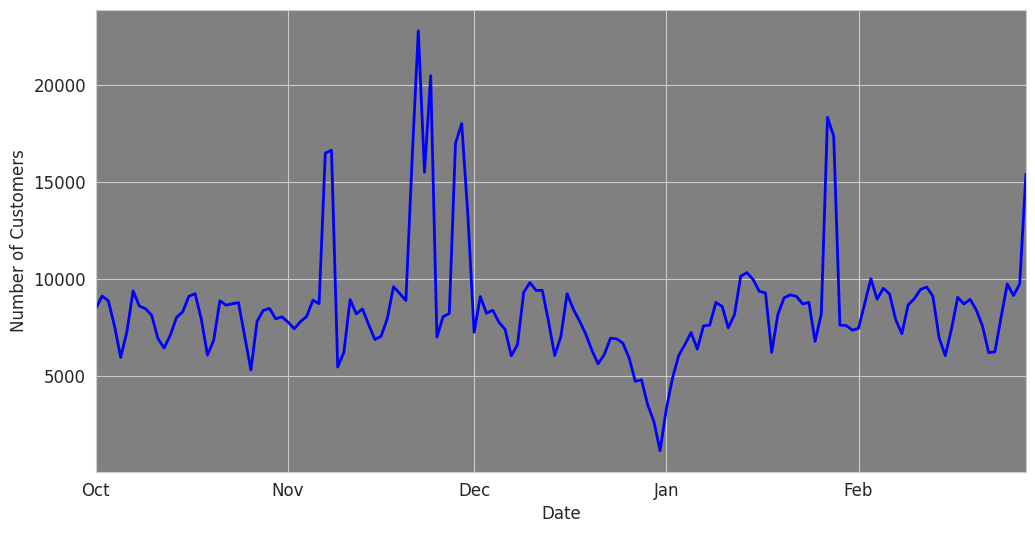

In [15]:
daily_customers = data.groupby('date').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
plt.plot(daily_customers['date'], daily_customers['count'], color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Customers')
locator = plt.matplotlib.dates.MonthLocator()
format = plt.matplotlib.dates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(format)
plt.xlim(daily_customers['date'].min(), daily_customers['date'].max())
plt.gca().set_facecolor('gray')
plt.show()
plt.close()

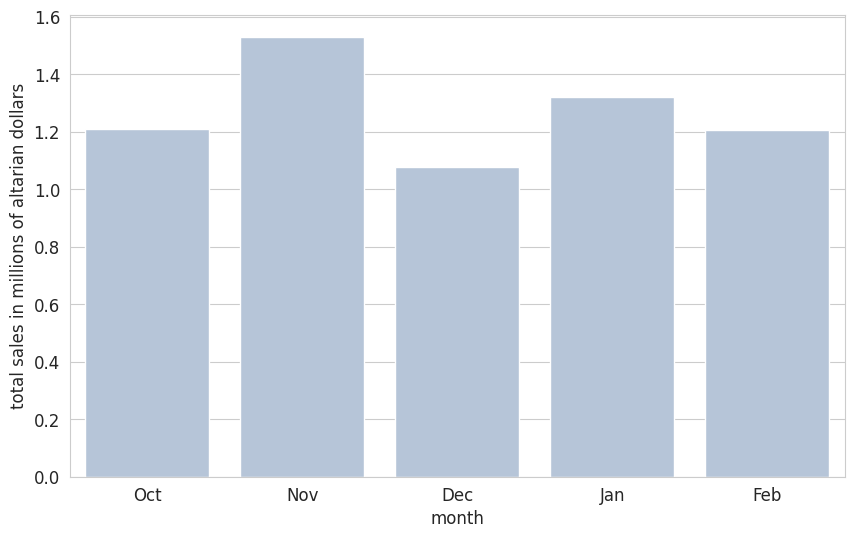

In [16]:
monthly_sales = data.groupby('month')['price'].sum().reset_index()
monthly_sales['sales_in_millions'] = monthly_sales['price'] / 1_000_000
monthly_sales['month_str'] = monthly_sales['month'].dt.strftime('%b')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month_str', y='sales_in_millions', data=monthly_sales, color='#B0C4DE')
plt.xlabel('month')
plt.ylabel('total sales in millions of altarian dollars')
plt.show()
plt.close()


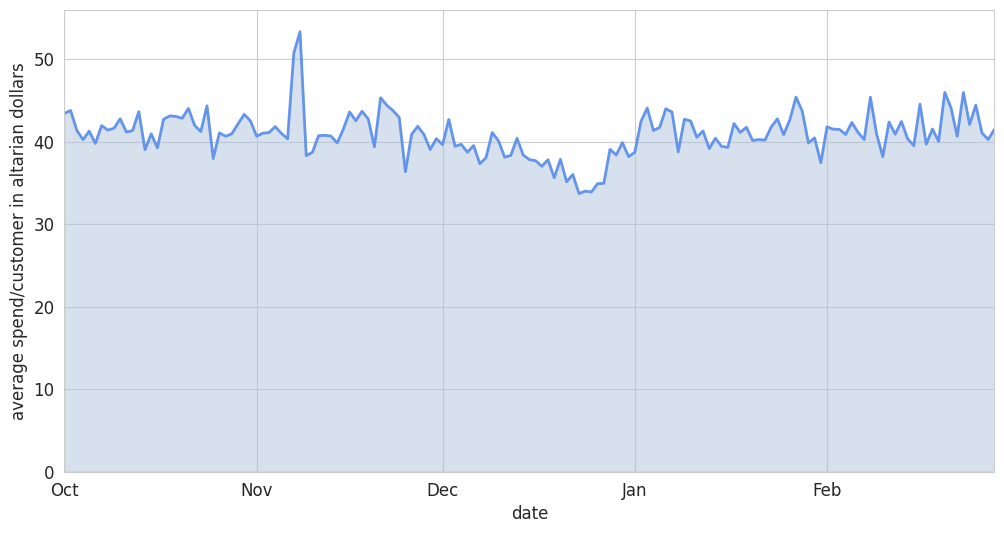

In [17]:
daily_data = data.groupby('date').agg(
    total_spend=('price', 'sum'),
    total_customers=('user_id', 'nunique') 
).reset_index()
daily_data['avg_spend_per_customer'] = daily_data['total_spend'] / daily_data['total_customers']
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['avg_spend_per_customer'], color='#6495ED', linewidth=2)
plt.fill_between(daily_data['date'], daily_data['avg_spend_per_customer'], color='#B0C4DE', alpha=0.5)
plt.xlabel('date')
plt.ylabel('average spend/customer in altarian dollars')
locator = plt.matplotlib.dates.MonthLocator()
format = plt.matplotlib.dates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(format)
plt.xlim(daily_data['date'].min(), daily_data['date'].max())
plt.ylim(bottom=0)
plt.show()
plt.close()